<a href="https://colab.research.google.com/github/arizky012/Deep-Learning/blob/master/02_inception_tomato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pickle
import cv2
import keras

from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Input, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer

from os import listdir
from google.colab import drive
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
drive.mount('/content/drive')
%cd drive/'My Drive'/deeplearn-classroom

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/deeplearn-classroom


In [0]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((299, 299))
image_size = 0
directory_root = './plantvillage/'
width=299
height=299
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
image_list, label_list = [], []
try:
    print("Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"Processing {plant_disease_folder}")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

Loading images ...
Processing Tomato___Spider_mites Two-spotted_spider_mite
Processing Tomato___Tomato_mosaic_virus
Processing Tomato___Septoria_leaf_spot
Processing Tomato___Early_blight
Processing Tomato___Bacterial_spot
Processing Tomato___Leaf_Mold
Processing Tomato___Target_Spot
Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus
Processing Tomato___healthy
Processing Tomato___Late_blight
Image loading completed
CPU times: user 77 µs, sys: 23 µs, total: 100 µs
Wall time: 104 µs


In [0]:
image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
base_model = InceptionV3(weights=None, include_top=False, input_tensor=Input(shape = (width, height, depth)))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)

predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS), metrics=["accuracy"])

In [0]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
50/50 [==============================] - 88s 2s/step - loss: 2.3809 - acc: 0.2938 - val_loss: 13.1898 - val_acc: 0.1300
Epoch 2/50
50/50 [==============================] - 62s 1s/step - loss: 2.1756 - acc: 0.3531 - val_loss: 14.7481 - val_acc: 0.0850
Epoch 3/50
50/50 [==============================] - 62s 1s/step - loss: 2.3245 - acc: 0.2950 - val_loss: 14.6780 - val_acc: 0.0850
Epoch 4/50
50/50 [==============================] - 62s 1s/step - loss: 2.3355 - acc: 0.2694 - val_loss: 14.7481 - val_acc: 0.0850
Epoch 5/50
50/50 [==============================] - 62s 1s/step - loss: 2.0377 - acc: 0.3212 - val_loss: 14.7481 - val_acc: 0.0850
Epoch 6/50
50/50 [==============================] - 62s 1s/step - loss: 1.6721 - acc: 0.4125 - val_loss: 6.0388 - val_acc: 0.1325
Epoch 7/50
50/50 [==============================] - 62s 1s/step - loss: 1.6490 - acc: 0.4419 - val_loss: 5.0480 - val_a

In [0]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

400/400 [==============================] - 4s 11ms/step
Test Accuracy: 60.25


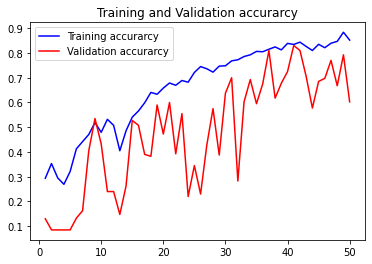

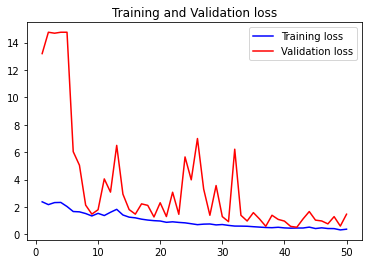

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=25, verbose=1
    )

Epoch 1/25
50/50 [==============================] - 62s 1s/step - loss: 0.3618 - acc: 0.8731 - val_loss: 2.1739 - val_acc: 0.5550
Epoch 2/25
50/50 [==============================] - 62s 1s/step - loss: 0.3611 - acc: 0.8731 - val_loss: 3.7342 - val_acc: 0.3875
Epoch 3/25
50/50 [==============================] - 62s 1s/step - loss: 0.2932 - acc: 0.8931 - val_loss: 1.0871 - val_acc: 0.6775
Epoch 4/25
50/50 [==============================] - 62s 1s/step - loss: 0.3554 - acc: 0.8750 - val_loss: 1.6363 - val_acc: 0.6000
Epoch 5/25
50/50 [==============================] - 62s 1s/step - loss: 0.3676 - acc: 0.8738 - val_loss: 1.9865 - val_acc: 0.5600
Epoch 6/25
50/50 [==============================] - 62s 1s/step - loss: 0.3375 - acc: 0.8844 - val_loss: 1.7922 - val_acc: 0.5975
Epoch 7/25
50/50 [==============================] - 62s 1s/step - loss: 0.2746 - acc: 0.9038 - val_loss: 1.5025 - val_acc: 0.6500
Epoch 8/25
50/50 [==============================] - 62s 1s/step - loss: 0.3113 - acc: 0.89

In [0]:
img = cv2.imread('tomat.jpg')
img2show = cv2.resize(img,(500,500))
img = cv2.resize(img,(299,299))
img = np.reshape(img,[1,299,299,3])

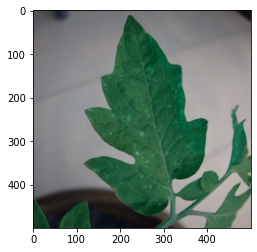

In [0]:
plt.imshow(img2show)
plt.show()

In [0]:
predict(img)

Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [0]:
def predict(image):
    try:
        lab = label_binarizer.classes_
        pred = model.predict(image)
        for cls in pred:
          for x in range(1,10):
            if cls[x] > 0:
              print(lab[x])
    except Exception as e:
        print(f"Error : {e}")
        return None